In [209]:
import sys
sys.path.insert(0, "src")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

from mpl_toolkits.axes_grid1.inset_locator import (
    InsetPosition,
    mark_inset
)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
plt.rc("text.latex", preamble=r"\usepackage{bm}")


# Edge Dislocations Functions

In [210]:
def ux_func(x: float, y: float, poisson_ratio: float, bx: float, offset: np.array=None) -> float:
    """
    TODO

    Args:
        x (float): x coordinate
        y (float): y coordinate
        poisson_ratio (float):
        bx (float): x element of burgers vector
        offset (None|np.aray): offset for dislocation. If None, then offset is 0

    Returns:
        float: x component of displacement for an edge dislocation
    """

    if offset is None:
        offset = np.array([0, 0])

    x = x - offset[0]
    y = y - offset[1]

    denom = 2 * (1 - poisson_ratio) * (x**2 + y**2)
    ret = np.arctan2(y, x) + x * y / denom

    return bx / (2 * np.pi) * ret


def uy_func(x: float, y: float, poisson_ratio: float, by: float, offset:np.array=None) -> float:
    """
    TODO

    Args:
        x (float): x coordinate
        y (float): y coordinate
        poisson_ratio (float):
        by (float): y element of burgers vector
        offset (None|np.aray): offset for dislocation. If None, then offset is 0

    Returns:
        float: y component of displacement for an edge dislocation
    """

    if offset is None:
        offset = np.array([0, 0])

    x = x - offset[0]
    y = y - offset[1]

    sum1 = 1 - 2 * poisson_ratio
    sum1 /= 4 * (1 - poisson_ratio)
    sum1 *= np.log(x**2 + y**2)

    sum2 = x**2 - y**2
    sum2 /= 4 * (1 - poisson_ratio) * (x**2 + y**2)

    return - by/(2 * np.pi) * (sum1 + sum2)


def density(
    x: float,
    y: float,
    G: np.array,
    etas: np.array,
    u: np.array
) -> np.array:
    """
    TODO

    Args:
        x (float):
        y (float):
        G (np.array): reciprocal vectors
        etas (np.array): amplitude magnitudes
        u (np.array): displacement

    Returns:
        np.array: TODO
    """

    eta_count = etas.shape[0]
    r = np.array([x, y])

    imag = complex(0, 1)

    n = np.zeros(x.shape, dtype=complex)
    for i in range(eta_count):

        amplitude = etas[i].astype(complex)
        amplitude *= np.exp(imag * (G[i, 0] * r[0] + G[i, 1] * r[1]))
        amplitude *= np.exp(imag * (G[i, 0] * u[0] + G[i, 1] * u[1]))

        n += amplitude

    n += np.conj(n)

    if np.max(np.imag(n)) != 0.0:
        print("WARNING: Im[n] != 0")

    n = np.real(n)

    return n


def Q_op(arr: np.array, dr: float, G: np.array, axis: int, conj: bool=False) -> float:
    """
    TODO

    Args:
        arr (np.array):
        dr (np.array): grid spacing
        G (np.array):
        axis (int): 0 for x, 1 for y
        conj (bool): If True, complex conjugate of operator is used.

    Returns:
        float:
    """

    ret_rhs = arr.copy().astype(complex)
    ret_rhs *= complex(0, 1) * G[axis]

    ret_lhs = arr.copy()
    ret_lhs = np.gradient(arr, dr, axis=int(not bool(axis)))

    return ret_lhs + int(conj) * ret_rhs


def laplacian(arr: np.array, dr: float) -> np.array:

    grad_y, grad_x = np.gradient(arr, dr)
    grad2_x = np.gradient(grad_x, dr, axis=1)
    grad2_y = np.gradient(grad_y, dr, axis=0)

    return grad2_x + grad2_y


def G_op(arr: np.array, dr: float, G: np.array):

    grad_y, grad_x = np.gradient(arr, dr)
    grad2 = laplacian(arr, dr)

    ret = 2 * complex(0,1) * (G[0] * grad_x + G[1] * grad_y)

    return grad2.astype(complex) + ret


def calc_stress(etas: np.array, G: np.array, dr: float, axes=[0, 1]) -> np.array:
    """
    TODO

    Args:
        etas (np.array):
        G (np.array): recipricol vectors
        dr (float): grid spacing
        axes (list, optional): Should have 2 entries Defines the tensor indeces.
            0 = x, 1 = y. So an axes of :code:`[0, 1]` corresponds to
            :math:`\\sigma_{xy}`, while an axes of :code:`[1, 1]` corresponds to
            :math:`\\sigma_{yy}`. Defaults to [0, 1].

    Returns:
        np.array:
    """

    eta_count: int = etas.shape[0]

    stress = np.zeros(etas[0].shape, dtype=complex)
    for m in range(eta_count):

        p1 = G_op(etas[m], dr, G[m])
        p1 = Q_op(p1, dr, G[m], axis=axes[0])

        p2 = Q_op(np.conj(etas[m]), dr, G[m], axis=axes[1], conj=True)
        p3 = G_op(etas[m], dr, G[m])

        p4 = Q_op(np.conj(etas[m]), dr, G[m], axis=axes[1], conj=True)
        p4 = Q_op(p4, dr, G[m], axis=axes[0], conj=True)

        stress += p1 * p2 + p3 * p4

    stress = stress + np.conj(stress)

    if np.max(np.imag(stress)) != 0.0:
        print("WARNING: Im[\sigma] != 0")

    stress = np.real(stress)

    return stress


def reconstruct_u(axis: int, m: int, l: int, etas: np.array, G: np.array) -> np.array:
    """
    Reconstruct displacement from the amplitudes :code:`\\eta_m`

    Args:
        axis (int): 0 means reconstruct u_x, 1 means reconstruct u_y
        m (int): arbitrary index for amplitude, :math:`m \\neq l`
        l (int): arbitrary index for amplitude, :math:`m \\neq l`
        etas (np.array): complex amplitudes
        G (np.array): reciprocal vectors

    Returns:
        np.array: u_x or u_y
    """

    i = axis
    j = int(not bool(i))

    ang = lambda x: np.arctan2(np.imag(x), np.real(x))

    numer = G[l,j] * ang(etas[m]) - G[m,j] * ang(etas[l])
    denom = G[m,i] * G[l,j] - G[m,j] * G[l,i]

    return numer / denom


# From file 2D

In [211]:
# SETTINGS

BASE_PATH = "/media/max/Storage/sim_saves/hsl/grain_grow"

#sim_name = "n0_4_stable_defects_n0_-0.03_ll"
#sim_name = "n0_grain_grow_n0_-0.03"
#sim_name = "n0_solid_n0_-0.03"

#sim_name = "hsl_4_stable_defects"
sim_name = "maik_3"

compare_name: str|None = None #"n0_0_defects_grain_grow_ll"  # can be None to not do a comparssion

fig_save_path = f"/home/max/projects/strained_apfc/tmp/{sim_name}"

index = -1
dpi = 150
fix_min_max_kwargs = { # can be None per plot for no fix
    "displacement": None,#{"bin_nos": 1000, "pt_count_threshhold": 20},
    "stress": {"bin_nos": 1000, "pt_count_threshhold": 20},
    "comp_phi_density": None,#{"bin_nos": 1000, "pt_count_threshhold": 20},
    "comp_n0": None,#{"bin_nos": 1000, "pt_count_threshhold": 20},
    "velocity": None#{"bin_nos": 1000, "pt_count_threshhold": 20}
}

show_plots = True

detect_defects = False
defect_radius_extension: float = None # can be None for no extension
defect_indeces = range(1, 11)  # can be None for all
lin_fit_range = None #range(10, 40) # can be None for all

sim_path = f"{BASE_PATH}/{sim_name}"
compare_path: str = f"{BASE_PATH}/{compare_name}"

do_animation = {
    "etas": False,
    "displacement": False, # not implemented
    "phi_density": False,
    "stress": False, # not implemented
    "n0": False, # not implemented
    "diff_phi_density": False,
    "diff_n0": False, # not implemented,
    "velocity": False,
    "velocity_arrow": False,
}
anim_fps = 10
num_writes = 100 # 85 # can be None to include all

stress_theo_radius = 40
do_stress_theo_comp = False

velocity_arrow_spacing = 4
velocity_arrow_cmap = "inferno"

In [212]:
# Load the fields into memory

from typing import Union

from strained_apfc.manage import utils
from strained_apfc.manage import read_write as rw

from strained_apfc.calculations import defect_detection

def calc_density(
    etas: np.array, G: np.array, r: np.array, n0: Union[np.array, None]=None
) -> np.array:

    if n0 is None:
        n0 = np.zeros(etas[0].shape, dtype=float)

    n = np.zeros(etas[0].shape, dtype=complex)

    imag = complex(0, 1)

    for i in range(etas.shape[0]):
        ampl = etas[i].copy()
        ampl *= np.exp(imag * (G[i, 0] * r[0] + G[i, 1] * r[1]))
        n += ampl

    n += np.conj(n)

    if np.max(np.imag(n)) != 0.0:
        print("WARNING: Im[n] != 0")

    n = np.real(n)
    n += n0

    return n

def get_fields(
    sim_path:str, index:int, compare_path: Union[str, None]=None
):

    config = utils.get_config(sim_path)
    eta_path = f"{sim_path}/eta_files/0.0000/"

    eta_count = len(config["G"])
    include_n0 = utils.simulates_n0(config["simType"])
    include_velocity = utils.simulates_velocity(config["simType"])

    x = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
    xm, ym = np.meshgrid(x, x)
    r = np.array([xm, ym])
    imag = complex(0,1)
    G = np.array(config["G"])

    etas = rw.read_all_etas_at_line(
        eta_path, index, config["numPtsX"], config["numPtsY"], eta_count, complex
    )

    n0 = 0
    if include_n0:
        n0 = rw.read_arr_at_line(
            f"{eta_path}/n0.txt", index, config["numPtsX"], config["numPtsY"]
        )

    velocity = 0
    if include_velocity:
        vel_shape = (2, config["numPtsX"], config["numPtsY"])
        velocity = rw.read_vector_field_hack(
            vel_shape,
            rw.read_arr_at_line,
            f"{eta_path}/velocity.txt",
            index,
            dtype=float
        )

    split_etas = np.zeros(etas.shape, dtype=float)
    for i in range(etas.shape[0]):
        x_cut = etas[i].shape[0] // 2
        split_etas[i] = np.imag(etas[i])
        split_etas[i, :, x_cut:] = np.real(etas[i, :, x_cut:])

    phi = np.zeros(etas[0].shape)
    for i in range(etas.shape[0]):
        phi += np.real(etas[i] * np.conj(etas[i]))
    phi *= 2

    n = calc_density(etas, G, r, n0 if include_n0 else None)

    ux = reconstruct_u(0, 0, 2, etas, G)
    uy = reconstruct_u(1, 0, 2, etas, G)

    dr = np.abs(np.diff(x)[0])

    stress_xy = calc_stress(etas, G, dr, axes=[0,1])
    stress_xx = calc_stress(etas, G, dr, axes=[0,0])
    stress_yy = calc_stress(etas, G, dr, axes=[1,1])

    compare_diff = None
    compare_diff_density = None
    compare_diff_n0 = None
    compare_include_n0 = True

    if compare_name is not None:

        compare_config = utils.get_config(compare_path)
        compare_eta_path = f"{compare_path}/eta_files/0.0000/"
        compare_include_n0 = utils.simulates_n0(compare_config["simType"])

        compare_etas = rw.read_all_etas_at_line(
            compare_eta_path,
            index,
            compare_config["numPtsX"],
            compare_config["numPtsY"],
            eta_count,
            complex
        )

        compare_phi = np.zeros(etas[0].shape)
        for i in range(etas.shape[0]):
            compare_phi += np.real(compare_etas[i] * np.conj(compare_etas[i]))
        compare_phi *= 2

        compare_diff = (compare_phi - phi)**2

        compare_diff_n0 = 0
        compare_density = 0
        compare_n0 = 0
        if compare_include_n0:
            compare_n0 = rw.read_arr_at_line(
                f"{compare_eta_path}/n0.txt",
                index,
                compare_config["numPtsX"],
                compare_config["numPtsY"]
            )

            compare_diff_n0 = compare_n0 - n0
            compare_diff_n0 *= np.conj(compare_diff_n0)
            compare_diff_n0 = np.real(compare_diff_n0)

        compare_density = calc_density(
            compare_etas, np.array(compare_config["G"]), r,
            compare_n0 if include_n0 else None
        )
        compare_diff_density = (compare_density - n)**2

    ret = (
        xm, ym, etas, phi, n, n0, velocity, ux, uy,
        stress_xy, stress_xx, stress_yy,
        compare_diff, compare_diff_density, compare_diff_n0,
        include_n0, compare_include_n0, include_velocity
    )

    return ret

(
    xm, ym, etas, phi, n, n0, velocity, ux, uy,
    stress_xy, stress_xx, stress_yy,
    compare_diff, compare_diff_density, compare_diff_n0,
    include_n0, compare_include_n0, include_velocity
) = get_fields(sim_path, index, compare_path)

print("Phi max:", np.max(phi), "Phi min:", np.min(phi))

if detect_defects and include_n0:
    defect_centers = defect_detection.get_defects_center(
        n0, xm, ym, defect_radius_extension
    )


Phi max: 0.1256861842087431 Phi min: 2.2422626255927863e-13


In [213]:
# Plot function definitions

def fix_min_max(
    arr: np.array, bin_nos: int=100, pt_count_threshhold: int=10
) -> tuple[float, float]:
    """
    Generates a min and max value for plotting the :code:`arr`, while ignoring
    the highest and lowest values if there are not many of them.

    Essentially tries to get rid of outliers.

    This is done by first calculating a histogram of the values in :code:`arr`.
    Then for each bin it is checked whether more values than
    :code:`pt_count_threshhold` are in a bin. The lowest and highest bin
    that fulfill this condition will be used to determine the bounds.

    Args:
        arr (np.array): array to check
        bin_nos (int, optional): Number of bins. Defaults to 100.
        pt_count_threshhold (int, optional): The amount of datapoints that should
            be in a bin, for that bin to be counted. Defaults to 10.

    Returns:
        tuple[float, float]: The new min and max values.
    """


    hist, bin_edges = np.histogram(arr.flatten(), bin_nos)

    # The bin_edges have one value more than the hist array to include the last boundary.
    # --> for the max index we want to look at the bin_edges value after
    # the index of the last hist value that fulfills the condition

    first_true = hist.shape[0]
    last_true = 0
    for i in range(hist.shape[0]):
        is_true = hist[i] > pt_count_threshhold
        if not is_true:
            continue
        first_true = i if i < first_true else first_true
        last_true = i if i > last_true else last_true

    new_min = bin_edges[first_true]
    new_max = bin_edges[last_true+1]

    return new_min, new_max

def plot_etas_re_im(
    xm,
    ym,
    etas,
    cbar_y0=0.07,
    cbar_height=0.05,
    wspace=0.05,
    hspace=0.05,
    dpi=100,
    cbar_ticks=5,
    contourf_color_count=100,
    cmap="coolwarm",
    fig_save_path=None,
    fig=None,
    axs=None
):

    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 3, dpi = dpi)

    eta_max = -1e10
    eta_min = 1e10

    eta_max = np.max([eta_max, np.max(np.real(etas))])
    eta_max = np.max([eta_max, np.max(np.imag(etas))])
    eta_min = np.min([eta_min, np.min(np.real(etas))])
    eta_min = np.min([eta_min, np.min(np.imag(etas))])

    ticks_cbar = np.linspace(eta_min, eta_max, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(eta_min, eta_max, contourf_color_count, endpoint=True)

    for i in range(etas.shape[0]):

        ax_re = axs[0][i]
        ax_im = axs[1][i]

        ax_re.set_aspect("equal")
        ax_im.set_aspect("equal")

        ax_re.set_title(f"$\\mathrm{{Re}}\\left[\\eta_{i+1}\\right]$")
        ax_im.set_title(f"$\\mathrm{{Im}}\\left[\\eta_{i+1}\\right]$")

        ax_re.set_xticklabels([])
        ax_re.set_yticklabels([])
        ax_im.set_xticklabels([])
        ax_im.set_yticklabels([])

        cont = ax_re.contourf(xm, ym, np.real(etas[i]), ticks_plot, cmap=cmap)
        cont.set_clim(eta_min, eta_max)

        cont = ax_im.contourf(xm, ym, np.imag(etas[i]), ticks_plot, cmap=cmap)
        cont.set_clim(eta_min, eta_max)

    pos = [
        axs[1][0].get_position().x0,
        axs[1][0].get_position().y0 - cbar_y0,
        axs[1][-1].get_position().x0 + axs[1][-1].get_position().width - axs[1][0].get_position().x0,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__etas.png", bbox_inches="tight")

def plot_stresses(
    xm,
    ym,
    stress_xy,
    stress_xx,
    stress_yy,
    dpi=100,
    cbar_tics=5,
    contourf_color_count=100,
    cmap="coolwarm",
    cbar_y0=0.085,
    cbar_height=0.05,
    wspace=0.05,
    hspace=0.05,
    fig_save_path=None,
    fix_min_max_kwargs=None,
    fig=None,
    axs=None
):

    if fig or axs is None:
        fig, axs = plt.subplots(nrows=1, ncols=3, dpi=dpi)
    ax1, ax2, ax3 = axs

    stresses = (stress_xy, stress_xx, stress_yy)
    stress_max = -1e10
    stress_min = 1e10
    for stress in stresses:
        stress_min = np.min([stress_min, np.min(stress)])
        stress_max = np.max([stress_max, np.max(stress)])

    if fix_min_max_kwargs is not None:
        stress_min, stress_max = fix_min_max(np.array(stresses), **fix_min_max_kwargs)

    ticks_cbar = np.linspace(stress_min, stress_max, cbar_tics, endpoint=True)
    ticks_plot = np.linspace(stress_min, stress_max, contourf_color_count, endpoint=True)

    for ax, stress in zip(axs, stresses):

        ax.set_aspect("equal")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        cont = ax.contourf(xm, ym, stress, ticks_plot, cmap=cmap)
        cont.set_clim(stress_min, stress_max)

    ax1.set_title("$\\sigma_{xy}$")
    ax2.set_title("$\\sigma_{xx}$")
    ax3.set_title("$\\sigma_{yy}$")

    pos = [
        axs[0].get_position().x0,
        axs[0].get_position().y0 - cbar_y0,
        axs[-1].get_position().x0 + axs[-1].get_position().width - axs[0].get_position().x0,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__stress.png", bbox_inches="tight")

def plot_displacement(
    xm,
    ym,
    ux,
    uy,
    dpi=100,
    cmap="coolwarm",
    cbar_ticks=5,
    contourf_color_count=100,
    cbar_y0=0.07,
    cbar_height=0.025,
    wspace=0.05,
    hspace=0.05,
    fig_save_path=None,
    fix_min_max_kwargs=None,
    fig=None,
    axs=None
):

    max_ = np.max(ux)
    max_ = np.max([max_, np.max(uy)])
    min_ = np.min(ux)
    min_ = np.min([min_, np.min(uy)])

    if fix_min_max_kwargs is not None:
        min_, max_ = fix_min_max(np.array([ux, uy]), **fix_min_max_kwargs)

    ticks_cbar = np.linspace(min_, max_, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(min_, max_, contourf_color_count, endpoint=True)

    if np.diff(ticks_plot)[0] == 0:
        ticks_plot = 100

    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 2, dpi=dpi)
    ax_x, ax_y = axs

    for ax in axs:
        ax.set_aspect("equal")
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    cont = ax_x.contourf(xm, ym, ux, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    cont = ax_y.contourf(xm, ym, uy, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    ax_x.set_title("$u_x$")
    ax_y.set_title("$u_y$")

    pos = [
        axs[0].get_position().x0,
        axs[0].get_position().y0 - cbar_y0,
        axs[-1].get_position().x0 + axs[-1].get_position().width - axs[0].get_position().x0,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    cbar = plt.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__u.png", bbox_inches="tight")

def plot_phi_and_density(
    xm,
    ym,
    phi,
    n,
    contourf_color_count=100,
    cbar_ticks=5,
    cmap="coolwarm",
    dpi=100,
    cbar_y0=0.07,
    cbar_height=0.025,
    wspace=0.05,
    hspace=0.05,
    inset_size=20,
    inset_window_pos=[0.6, 0.6, 0.3, 0.3],
    inset_offset=np.array([0,0]),
    show_inset=True,
    fig_save_path=None,
    fig=None,
    axs=None
):

    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 2, dpi=dpi)

    ax1, ax2 = axs
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    gen_conturf_plot(
        xm, ym, phi, fig, ax1,
        contourf_color_count=contourf_color_count,
        cbar_ticks=cbar_ticks,
        cmap=cmap,
        cbar_y0=cbar_y0,
        cbar_height=cbar_height
    )
    ax1.set_title("$\Phi$")
    if show_inset:
        plot_density_w_inset(
            xm, ym, n, inset_size, offset=inset_offset,
            contourf_color_count=contourf_color_count,
            cbar_ticks=cbar_ticks,
            cmap=cmap,
            cbar_y0=cbar_y0,
            cbar_height=cbar_height,
            ax=ax2,
            fig=fig,
            inset_window_pos=inset_window_pos
        )
    else:
        gen_conturf_plot(
            xm, ym, n, fig, ax2,
            contourf_color_count=contourf_color_count,
            cbar_ticks=cbar_ticks,
            cmap=cmap,
            cbar_y0=cbar_y0,
            cbar_height=cbar_height
        )
    ax2.set_title("$n(r, u)$")

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__phi_density.png", bbox_inches="tight")

def gen_conturf_plot(
    xm,
    ym,
    arr,
    fig,
    ax,
    contourf_color_count=100,
    cbar_ticks=5,
    cmap="coolwarm",
    cbar_y0=0.07,
    cbar_height=0.025,
    fix_min_max_kwargs=None,
    save_name=None
):

    min_ = np.min(arr)
    max_ = np.max(arr)

    if fix_min_max_kwargs is not None:
        min_, max_ = fix_min_max(arr, **fix_min_max_kwargs)

    ticks_cbar = np.linspace(min_, max_, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(min_, max_, contourf_color_count, endpoint=True)

    if np.diff(ticks_plot)[0] == 0:
        ticks_plot = 100

    ax.set_aspect("equal")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    cont = ax.contourf(xm, ym, arr, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    pos = [
        ax.get_position().x0,
        ax.get_position().y0 - cbar_y0,
        ax.get_position().width,
        cbar_height
    ]
    cax = fig.add_axes(pos)

    fig.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)
    if save_name is not None:
        fig.savefig(save_name, bbox_inches="tight")

def plot_density_w_inset(
    xm,
    ym,
    n,
    size,
    offset=np.array([0, 0]),
    contourf_color_count=100,
    cbar_ticks=5,
    cmap="coolwarm",
    dpi=100,
    cbar_y0=0.05,
    cbar_height=0.025,
    wspace=0.05,
    hspace=0.05,
    ax=None,
    fig=None,
    inset_window_pos=[0.6, 0.6, 0.3, 0.3],
    fig_save_path=None
):

    xm_in_bounds = np.logical_and(xm[0,:] < offset[1]+size, xm[0,:] > offset[1]-size)
    ym_in_bounds = np.logical_and(ym[:,0] < offset[0]+size, ym[:,0] > offset[0]-size)

    xm_inset = xm[np.ix_(xm_in_bounds, ym_in_bounds)]
    ym_inset = ym[np.ix_(xm_in_bounds, ym_in_bounds)]
    n_inset = n[np.ix_(xm_in_bounds, ym_in_bounds)]

    min_ = np.min(n)
    max_ = np.max(n)

    ticks_cbar = np.linspace(min_, max_, cbar_ticks, endpoint=True)
    ticks_plot = np.linspace(min_, max_, contourf_color_count, endpoint=True)

    if ax is None or fig is None:
        fig = plt.figure(dpi=dpi)
        ax = plt.subplot(111)
        plt.subplots_adjust(wspace=wspace, hspace=hspace)

    ax.set_aspect("equal")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    cont = ax.contourf(xm, ym, n, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    #####

    ax_inset = plt.axes([0,0,1,1])
    inset_pos = InsetPosition(ax, inset_window_pos)
    ax_inset.set_axes_locator(inset_pos)

    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec='0')

    ax_inset.set_aspect("equal")
    ax_inset.set_xticklabels([])
    ax_inset.set_yticklabels([])

    cont = ax_inset.contourf(xm_inset, ym_inset, n_inset, ticks_plot, cmap=cmap)
    cont.set_clim(min_, max_)

    pos = [
        ax.get_position().x0,
        ax.get_position().y0 - cbar_y0,
        ax.get_position().width,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    fig.colorbar(cont, cax=cax, orientation="horizontal", ticks=ticks_cbar)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__density_w_inset.png", bbox_inches="tight")

def plot_diff(
    xm,
    ym,
    diff_etas,
    diff_n0,
    contourf_color_count=100,
    cbar_ticks=5,
    cmap="coolwarm",
    dpi=100,
    cbar_y0=0.05,
    cbar_height=0.025,
    wspace=0.05,
    hspace=0.05,
    fig_save_path=None,
    fig_file_name_suffix: str="",
    fig_titles: tuple[str] = None,
    fix_min_max_kwargs=None,
    fig=None,
    axs=None
):

    if fig_titles is None:
        fig_titles = (
            "$|\Phi_d - \Phi|^2$",
            "$|n_{0,d} - n_0|^2$"
        )

    ax1 = ax2 = None
    if fig is None or axs is None:

        if diff_n0 is not None:
            fig, axs = plt.subplots(1, 2, dpi=dpi)
        else:
            fig, axs = plt.subplots(1, 1, dpi=dpi)


    if diff_n0 is not None:
        ax1, ax2 = axs
    else:
        ax1 = plt.subplot(111)
        ax1 = axs

    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    gen_conturf_plot(
        xm, ym, diff_etas, fig, ax1,
        contourf_color_count=contourf_color_count,
        cbar_ticks=cbar_ticks,
        cmap=cmap,
        cbar_y0=cbar_y0,
        cbar_height=cbar_height,
        fix_min_max_kwargs=fix_min_max_kwargs
    )
    ax1.set_title(fig_titles[0])

    if diff_n0 is not None:
        gen_conturf_plot(
            xm, ym, diff_n0, fig, ax2,
            contourf_color_count=contourf_color_count,
            cbar_ticks=cbar_ticks,
            cmap=cmap,
            cbar_y0=cbar_y0,
            cbar_height=cbar_height,
            fix_min_max_kwargs=fix_min_max_kwargs
        )
        ax2.set_title(fig_titles[-1])

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__comp{fig_file_name_suffix}.png", bbox_inches="tight")

def plot_velocity(
    xm,
    ym,
    velocity,
    contourf_color_count=100,
    cbar_ticks=5,
    cmap="coolwarm",
    dpi=100,
    cbar_y0=0.07,
    cbar_height=0.025,
    wspace=0.05,
    hspace=0.05,
    fig_save_path=None,
    fig=None,
    axs=None,
    fix_min_max_kwargs=None
):

    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 2, dpi=dpi)

    ax_x, ax_y = axs
    ax_x.set_aspect("equal")
    ax_y.set_aspect("equal")

    ax_x.set_title("velocity x")
    ax_y.set_title("velocity y")

    gen_conturf_plot(
        xm, ym, velocity[0], fig, ax_x,
        contourf_color_count=contourf_color_count,
        cbar_ticks=cbar_ticks,
        cmap=cmap,
        cbar_y0=cbar_y0,
        cbar_height=cbar_height,
        fix_min_max_kwargs=fix_min_max_kwargs
    )
    gen_conturf_plot(
        xm, ym, velocity[1], fig, ax_y,
        contourf_color_count=contourf_color_count,
        cbar_ticks=cbar_ticks,
        cmap=cmap,
        cbar_y0=cbar_y0,
        cbar_height=cbar_height,
        fix_min_max_kwargs=fix_min_max_kwargs
    )

    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__velocity.png", bbox_inches="tight")

def plot_velocity_arrow(
    xm,
    ym,
    velocity,
    spacing=10,
    cmap="inferno",
    dpi=100,
    wspace=0.05,
    hspace=0.05,
    fig_save_path=None,
    fig=None,
    axs=None,
    cbar_y0=0.07,
    cbar_height=0.025,
    cbar_ticks=5
):

    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 1, dpi=dpi)

    axs.set_aspect("equal")
    axs.set_xticklabels([])
    axs.set_yticklabels([])

    axs.set_title("velocity")

    x = xm[::spacing, ::spacing]
    y = ym[::spacing, ::spacing]
    vx = velocity[0,::spacing, ::spacing]
    vy = velocity[1,::spacing, ::spacing]

    length = np.sqrt(vx**2 + vy**2)
    min_ = np.min(length)
    max_ = np.max(length)

    ticks_cbar = np.linspace(min_, max_, cbar_ticks, endpoint=True)

    quiver_plot = axs.quiver(x, y, vx, vy, length, cmap=cmap)

    pos = [
        axs.get_position().x0,
        axs.get_position().y0 - cbar_y0,
        axs.get_position().width,
        cbar_height
    ]
    cax = fig.add_axes(pos)
    fig.colorbar(quiver_plot, cax=cax, orientation="horizontal", ticks=ticks_cbar)

    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if fig_save_path is not None:
        fig.savefig(f"{fig_save_path}__velocity_arrow.png", bbox_inches="tight")


In [214]:
# Animation function definitions


def animate_velocity(
    writer, indeces, dpi, sim_path, compare_path, *args, **kwargs
):

    fig, axs = plt.subplots(1, 2, dpi=dpi)

    config = utils.get_config(sim_path)
    dt_per_write = config["dt"] * config["writeEvery"]

    with writer.saving(fig, "../tmp/velocity.gif", dpi):
        for i in indeces:

            (
                xm, ym, etas, phi, n, n0, velocity, ux, uy,
                stress_xy, stress_xx, stress_yy,
                compare_diff, compare_diff_density, compare_diff_n0,
                include_n0, compare_include_n0, include_velocity
            ) = get_fields(sim_path, i, compare_path)

            plot_velocity(xm, ym, velocity, *args, **kwargs, fig=fig, axs=axs)
            fig.suptitle(f"$\\tau = {i*dt_per_write:.2f}$")

            writer.grab_frame()

            for ax in axs:
                ax.cla()

            cbar = plt.gcf().get_axes()[-1]
            cbar.remove()

    plt.close(fig)

def animate_etas_re_im(
    writer, indeces, dpi, sim_path, compare_path, *args, **kwargs
):

    fig, axs = plt.subplots(2, 3, dpi=dpi)

    config = utils.get_config(sim_path)
    dt_per_write = config["dt"] * config["writeEvery"]

    with writer.saving(fig, "../tmp/etas.gif", dpi):
        for i in indeces:

            (
                xm, ym, etas, phi, n, n0, velocity, ux, uy,
                stress_xy, stress_xx, stress_yy,
                compare_diff, compare_diff_density, compare_diff_n0,
                include_n0, compare_include_n0, include_velocity
            ) = get_fields(sim_path, i, compare_path)

            plot_etas_re_im(xm, ym, etas, *args, **kwargs, fig=fig, axs=axs)
            fig.suptitle(f"$\\tau = {i*dt_per_write:.2f}$")

            writer.grab_frame()

            for ax_row in axs:
                for ax in ax_row:
                    ax.cla()

            cbar = plt.gcf().get_axes()[-1]
            cbar.remove()

    plt.close(fig)

def animate_phi_and_density(
    writer, indeces, dpi, sim_path, compare_path, *args, **kwargs
):

    fig, axs = plt.subplots(1, 2)

    fig.set_figwidth(6)
    fig.set_figheight(3)

    config = utils.get_config(sim_path)
    dt_per_write = config["dt"] * config["writeEvery"]

    with writer.saving(fig, "../tmp/phi_density.gif", dpi):
        for i in indeces:

            (
                xm, ym, etas, phi, n, n0, velocity, ux, uy,
                stress_xy, stress_xx, stress_yy,
                compare_diff, compare_diff_density, compare_diff_n0,
                include_n0, compare_include_n0, include_velocity
            ) = get_fields(sim_path, i, compare_path)

            plot_phi_and_density(
                xm, ym, phi, n,
                *args, **kwargs, fig=fig, axs=axs
            )
            title = f"$\\vspace{{-1em}}\\tau = {i*dt_per_write:.2f}\\vspace{{-1em}}$"
            plt.suptitle(title)

            writer.grab_frame()

            for ax in axs:
                ax.cla()

            cbar1 = plt.gcf().get_axes()[-1]
            cbar2 = plt.gcf().get_axes()[-2]
            cbar1.remove()
            cbar2.remove()

    plt.close(fig)

def animate_velocity_arrow(
    writer, indeces, dpi, sim_path, compare_path, *args, **kwargs
):

    fig, axs = plt.subplots(1, 1)

    fig.set_figwidth(4)
    fig.set_figheight(4)

    config = utils.get_config(sim_path)
    dt_per_write = config["dt"] * config["writeEvery"]

    with writer.saving(fig, "../tmp/velocity_arrow.gif", dpi):
        for i in indeces:

            (
                xm, ym, etas, phi, n, n0, velocity, ux, uy,
                stress_xy, stress_xx, stress_yy,
                compare_diff, compare_diff_density, compare_diff_n0,
                include_n0, compare_include_n0, include_velocity
            ) = get_fields(sim_path, i, compare_path)

            plot_velocity_arrow(
                xm, ym, velocity,
                *args, **kwargs, fig=fig, axs=axs
            )
            title = f"$\\vspace{{-1em}}\\tau = {i*dt_per_write:.2f}\\vspace{{-1em}}$"
            plt.suptitle(title)

            writer.grab_frame()
            axs.cla()

            cbar1 = plt.gcf().get_axes()[-1]
            cbar1.remove()

    plt.close(fig)

def animate_diff_phi_density(
    writer, indeces, dpi, sim_path, compare_path, *args, **kwargs
):

    fig, axs = plt.subplots(1, 2, dpi=dpi)

    config = utils.get_config(sim_path)
    dt_per_write = config["dt"] * config["writeEvery"]

    with writer.saving(fig, "../tmp/compare_phi_density.gif", dpi):
        for i in indeces:

            (
                xm, ym, etas, phi, n, n0, velocity, ux, uy,
                stress_xy, stress_xx, stress_yy,
                compare_diff, compare_diff_density, compare_diff_n0,
                include_n0, compare_include_n0, include_velocity
            ) = get_fields(sim_path, i, compare_path)


            plot_diff(
                xm, ym, compare_diff,
                compare_diff_density,
                *args, **kwargs, fig=fig, axs=axs
            )
            fig.suptitle(f"$\\tau = {i*dt_per_write:.2f}$")
            writer.grab_frame()

            for ax in axs:
                ax.cla()

            cbar1 = plt.gcf().get_axes()[-1]
            cbar1.remove()

            cbar2 = plt.gcf().get_axes()[-1]
            cbar2.remove()

    plt.close(fig)


In [215]:
# Setup Animation

FFMpegWriter = manimation.writers["ffmpeg"]
writer = FFMpegWriter(fps=anim_fps)

config = utils.get_config(sim_path)

if num_writes is None:
    num_writes = int(config["numT"] / config["writeEvery"]) - 1

dt_per_write = config["dt"] * config["writeEvery"]

all_times = [i * dt_per_write for i in range(num_writes)]


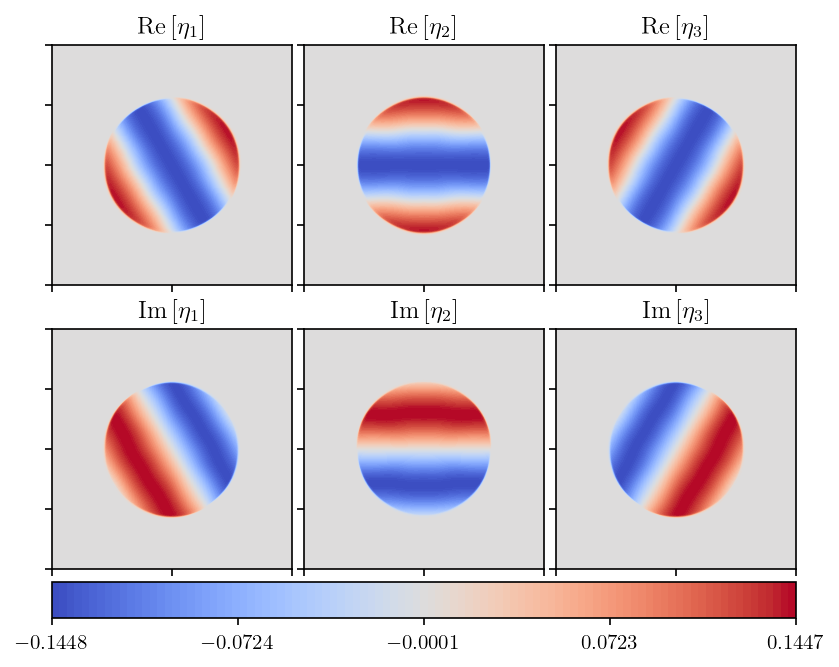

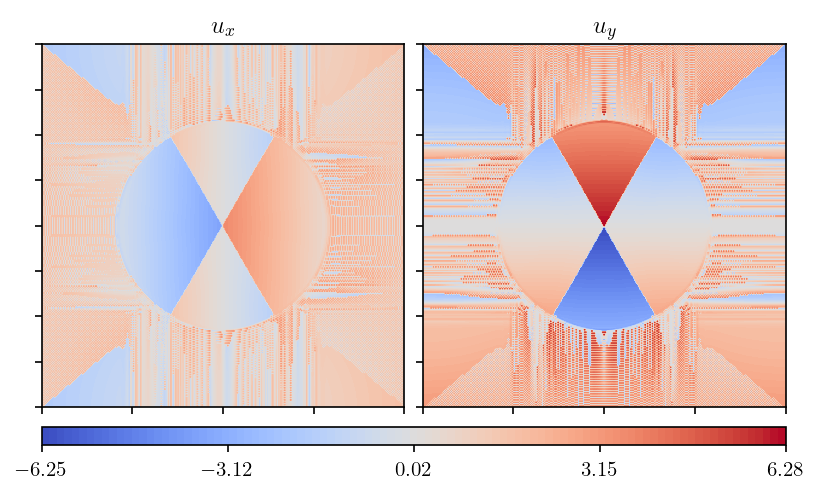

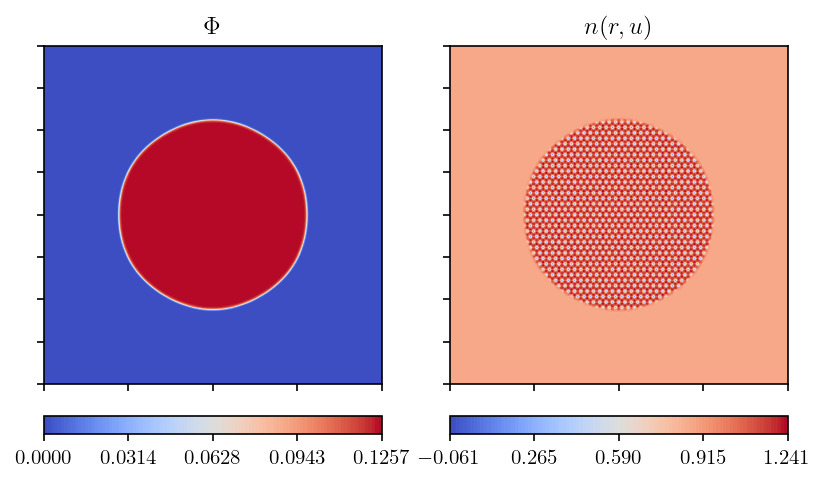

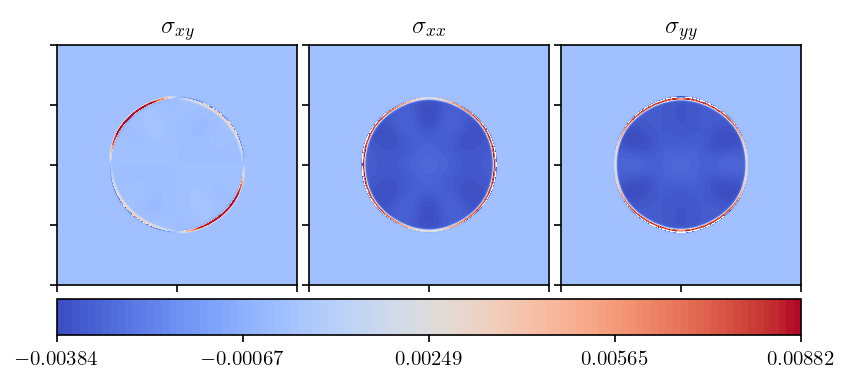

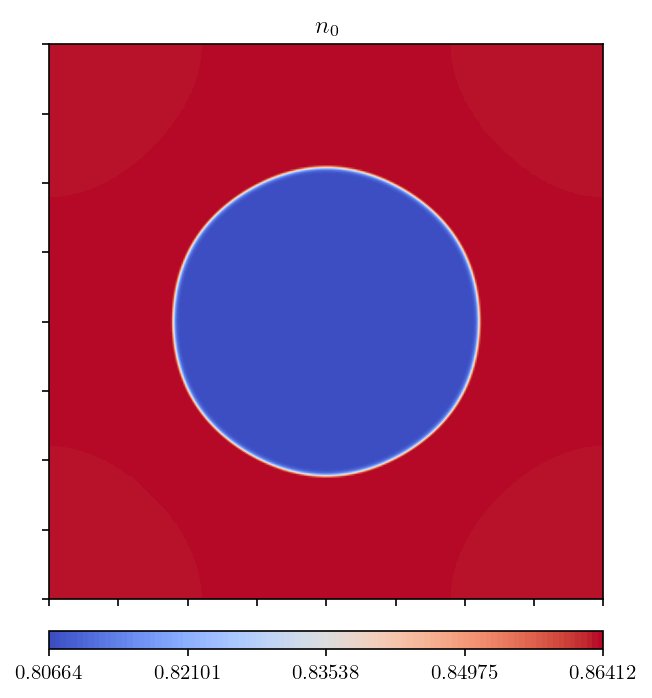

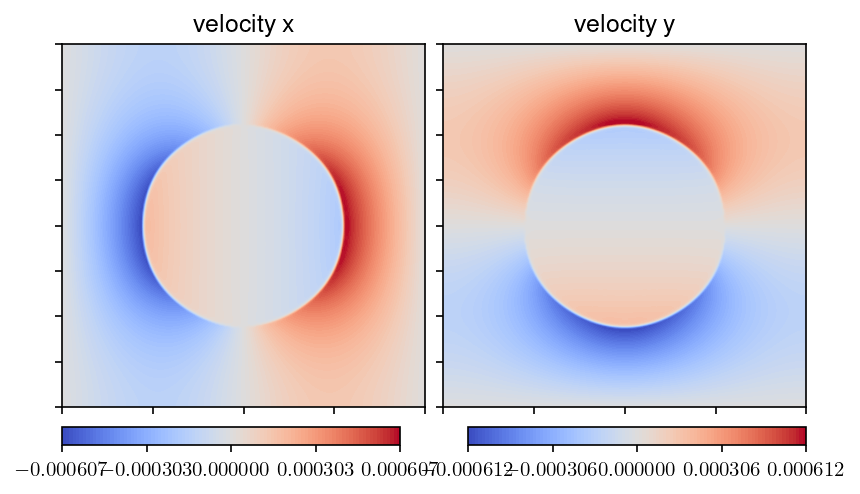

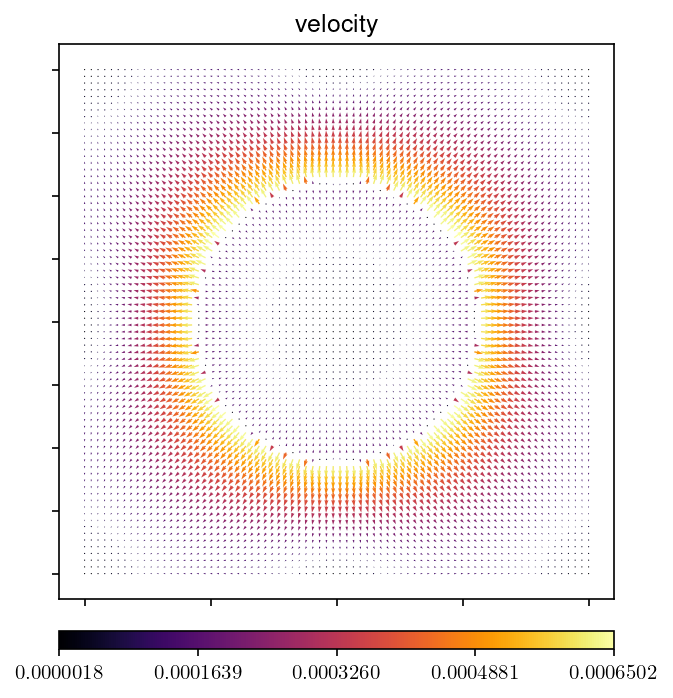

In [216]:
# Do the plotting

if show_plots:

    if do_animation["etas"]:
        animate_etas_re_im(
            writer, list(range(num_writes)), dpi,
            sim_path, compare_path,
            fig_save_path=fig_save_path
        )
    else:
        plot_etas_re_im(xm, ym, etas, dpi=dpi, fig_save_path=fig_save_path)

    plot_displacement(
        xm, ym, ux, uy,
        dpi=dpi, fig_save_path=fig_save_path,
        fix_min_max_kwargs=fix_min_max_kwargs["displacement"]
    )

    if do_animation["phi_density"]:
        animate_phi_and_density(
            writer, list(range(num_writes)), dpi,
            sim_path, compare_path,
            inset_size=40, inset_offset=[0,0], show_inset=False,
            inset_window_pos=[0.55, 0.55, 0.4, 0.4],
            wspace=0.2, fig_save_path=fig_save_path
        )
    else:
        plot_phi_and_density(
            xm, ym, phi, n, dpi=dpi,
            inset_size=40, inset_offset=[0,0], show_inset=False,
            inset_window_pos=[0.55, 0.55, 0.4, 0.4],
            wspace=0.2, fig_save_path=fig_save_path
        )

    #plot_density_w_inset(xm, ym, n, 10, offset=[0, 0], dpi= dpi)
    plot_stresses(
        xm, ym, stress_xy, stress_xx, stress_yy,
        dpi=dpi, fig_save_path=fig_save_path,
        fix_min_max_kwargs=fix_min_max_kwargs["stress"]
    )

    if include_n0:
        fig = plt.figure(dpi=dpi)
        ax = plt.subplot(111)
        ax.set_aspect("equal")
        gen_conturf_plot(
            xm, ym, n0, fig, ax,
            save_name=f"{fig_save_path}__n0.png"
        )
        ax.set_title("$n_0$")

    if include_velocity:
        if do_animation["velocity"]:
            animate_velocity(
                writer, list(range(num_writes)), dpi,
                sim_path, compare_path,
                fig_save_path=fig_save_path,
                fix_min_max_kwargs=fix_min_max_kwargs["velocity"]
            )
        else:
            plot_velocity(
                xm, ym, velocity, dpi=dpi, fig_save_path=fig_save_path,
                fix_min_max_kwargs=fix_min_max_kwargs["velocity"]
            )

        if do_animation["velocity_arrow"]:
            animate_velocity_arrow(
                writer, list(range(num_writes)), dpi,
                sim_path, compare_path,
                fig_save_path=fig_save_path,
                spacing=velocity_arrow_spacing,
                cmap=velocity_arrow_cmap
            )
        else:
            plot_velocity_arrow(
                xm, ym, velocity, dpi=dpi, fig_save_path=fig_save_path,
                spacing=velocity_arrow_spacing,
                cmap=velocity_arrow_cmap
            )

    if compare_name is not None:

        if do_animation["diff_phi_density"]:
            animate_diff_phi_density(
                writer, list(range(num_writes)), dpi,
                sim_path, compare_path,
                fig_save_path=fig_save_path,
                fig_file_name_suffix="phi_density",
                fig_titles=("$|\Phi_d - \Phi|^2$", "$|n_d - n|^2$"),
                fix_min_max_kwargs=fix_min_max_kwargs["comp_phi_density"]
            )
        else:
            plot_diff(
                xm, ym, compare_diff,
                compare_diff_density,
                dpi=dpi, fig_save_path=fig_save_path,
                fig_file_name_suffix="phi_density",
                fig_titles=("$|\Phi_d - \Phi|^2$", "$|n_d - n|^2$"),
                fix_min_max_kwargs=fix_min_max_kwargs["comp_phi_density"]
            )

        if include_n0 and compare_include_n0:
            plot_diff(
                xm, ym, compare_diff_n0,
                None,
                dpi=dpi, fig_save_path=fig_save_path,
                fig_file_name_suffix="n0",
                fig_titles=("$|n_{0,d} - n_0|^2$", "$|n_{0,d} - n_0|^2$"),
                fix_min_max_kwargs=fix_min_max_kwargs["comp_n0"]
            )

    plt.show()

# Defect Tracking

In [217]:
from strained_apfc.calculations import defect_detection

defect_radius_extension = 10
expected_number_of_defects = 2
sigma_mult = 10
filter_0 = False

dpi = 250


In [218]:
if False:

    config = utils.get_config(sim_path)

    if defect_indeces is None:
        defect_indeces = range(int(config["numT"] / config["writeEvery"]) - 1)

    defects = []
    time_indeces = []
    velocity_fields = []

    for time_index, i in enumerate(defect_indeces):

        (
            xm, ym, etas, phi, n, n0, velocity, ux, uy,
            stress_xy, stress_xx, stress_yy,
            compare_diff, compare_diff_density, compare_diff_n0,
            include_n0, compare_include_n0, include_velocity
        ) = get_fields(sim_path, i, compare_path)

        variation_arr = phi.copy()
        defect_pos = defect_detection.get_defects_center(
            variation_arr, xm, ym, expand_radius=defect_radius_extension
        )

        if defect_pos.shape != (expected_number_of_defects,2):
            continue

        defects.append(defect_pos)
        time_indeces.append(time_index)
        velocity_fields.append(velocity)

    fig, ax = plt.subplots(1, 1, dpi=dpi)

    ax.set_aspect("equal")
    ax.set_xlim([-config["xlim"], config["xlim"]])
    ax.set_ylim([-config["xlim"], config["xlim"]])

    for d in defects:
        ax.scatter(d[:,0], d[:,1])

    dt = config["writeEvery"] * config["dt"]

    velocities = []
    for i in range(1, len(defects)):

        xy = defects[i]
        xym1 = defects[i-1]

        vel = (xy[:,0] - xym1[:,0])**2
        vel += (xy[:,1] - xym1[:,1])**2
        vel /= dt * (time_indeces[i] - time_indeces[i-1])

        velocities.append(vel)

        print(vel)

    velocities = np.array(velocities)
    times = np.array(time_indeces[:-1]) * dt

    for d_i in range(expected_number_of_defects):

        vel_d = velocities[:,d_i]
        xy = np.array([times, vel_d])

        if filter_0:
            is_zero = xy[1,:] == 0
            xy = xy[:,~is_zero]

        mean = np.mean(xy[1,:])
        std = np.std(xy[1,:])

        in_set_logical = np.logical_and(
            xy[1,:] > mean - sigma_mult * std,
            xy[1,:] < mean + sigma_mult * std
        )

        in_set = xy[:,in_set_logical]
        out_of_set = xy[:,~in_set_logical]

        in_set_avg = np.mean(in_set[1])
        avg_str = f"{in_set_avg:.2e}"
        avg_str = avg_str.replace("e", "\\cdot 10^{")
        avg_str += "}"

        fig, ax = plt.subplots(1, 1, dpi=dpi)
        ax.hlines(
            in_set_avg,
            xmin=np.min(xy[0]),
            xmax=np.max(xy[0]),
            label=f"$\\bar{{v}} = {avg_str}$",
            color="grey",
            lw=0.5
        )
        ax.scatter(in_set[0], in_set[1], label="velocity")
        ax.scatter(out_of_set[0], out_of_set[1], c="grey", label=f"$\\leq{sigma_mult} \\sigma$")
        ax.set_title(f"Velocity $|\\bm{{v}}|$ of defect {d_i + 1}")
        plt.legend()

        print(f"Avg vel d{d_i}: {np.mean(in_set[1])}")

    plt.show()


## 2nd Version defect track

currently assumes to find 2 defects

In [219]:
import scipy

if detect_defects:

    config = utils.get_config(sim_path)

    if defect_indeces is None:
        defect_indeces = range(int(config["numT"] / config["writeEvery"]) - 1)

    defects = []
    time_indeces = []
    velocity_fields = []

    for time_index, i in enumerate(defect_indeces):

        (
            xm, ym, etas, phi, n, n0, velocity, ux, uy,
            stress_xy, stress_xx, stress_yy,
            compare_diff, compare_diff_density, compare_diff_n0,
            include_n0, compare_include_n0, include_velocity
        ) = get_fields(sim_path, i, compare_path)

        variation_arr = phi.copy()
        defect_pos = defect_detection.get_defects_center_by_minimum(
            variation_arr, xm, ym, expand_radius=defect_radius_extension
        )

        if defect_pos.shape != (expected_number_of_defects,2):
            continue

        defects.append(defect_pos)
        time_indeces.append(time_index)
        velocity_fields.append(velocity)

    fig, ax = plt.subplots(1, 1, dpi=dpi)

    ax.set_aspect("equal")
    ax.set_xlim([-config["xlim"], config["xlim"]])
    ax.set_ylim([-config["xlim"], config["xlim"]])

    for d in defects:
        ax.scatter(d[:,0], d[:,1])

    dt = config["writeEvery"] * config["dt"]

    distances = []
    for i in range(len(defects)):

        dist = (defects[i][0,0] - defects[i][1,0])**2
        dist += (defects[i][0,1] - defects[i][1,1])**2
        dist = np.sqrt(dist)

        distances.append(dist)

    velocities = []
    for i in range(1, len(defects)):

        distm1 = (defects[i-1][0,0] - defects[i-1][1,0])**2
        distm1 += (defects[i-1][0,1] - defects[i-1][1,1])**2
        distm1 = np.sqrt(distm1)

        vel = np.abs(distances[i] - distm1)
        vel /= dt * (time_indeces[i] - time_indeces[i-1])

        velocities.append(vel)

    velocities = np.array(velocities)
    times = np.array(time_indeces[:-1]) * dt
    times_full = np.array(time_indeces) * dt

    ##########################################



    ######################################################3

    vel_d = velocities
    xy = np.array([times, vel_d])

    if filter_0:
        is_zero = xy[1,:] == 0
        xy = xy[:,~is_zero]

    mean = np.mean(xy[1,:])
    std = np.std(xy[1,:])

    in_set_logical = np.logical_and(
        xy[1,:] > mean - sigma_mult * std,
        xy[1,:] < mean + sigma_mult * std
    )

    in_set = xy[:,in_set_logical]
    out_of_set = xy[:,~in_set_logical]

    in_set_avg = np.mean(in_set[1])
    avg_str = f"{in_set_avg:.2e}"
    avg_str = avg_str.replace("e", "\\cdot 10^{")
    avg_str += "}"

    fig, ax = plt.subplots(1, 1, dpi=dpi)
    ax.hlines(
        in_set_avg,
        xmin=np.min(xy[0]),
        xmax=np.max(xy[0]),
        label=f"$\\bar{{v}} = {avg_str}$",
        color="grey",
        lw=0.5
    )
    ax.scatter(in_set[0], in_set[1], label="velocity")
    ax.scatter(out_of_set[0], out_of_set[1], c="grey", label=f"$\\leq{sigma_mult} \\sigma$")
    ax.set_title(f"Velocity $|\\bm{{v}}|$")
    print(f"Avg vel: {np.mean(in_set[1])}")
    plt.legend()
    plt.show()

    ######################################################

    fig, ax = plt.subplots(1, 1, dpi=dpi)
    ax.scatter(distances[:-1], velocities)
    ax.set_xlabel("distances")
    ax.set_ylabel("velocities")
    plt.show()

    ######################################################

    if lin_fit_range is None:
        lin_fit_range = range(times_full.shape[0])

    times_fit = times_full[lin_fit_range]
    distances_fit = np.array(distances)[lin_fit_range]

    x_fit = np.linspace(np.min(times_full), np.max(times_full), 100)
    m, b = np.polyfit(times_fit, distances_fit, 1)
    lin_func = lambda x, m, b: m * x + b
    y_fit = lin_func(x_fit, m, b)

    m_str = f"{m:.2e}"
    m_str = m_str.replace("e", "\\cdot 10^{")
    m_str += "}"

    fig, ax = plt.subplots(1, 2, dpi=dpi, figsize=(8, 4))
    ax[0].scatter(times_full, distances, label="distances")
    ax[0].plot(x_fit, y_fit, c="grey", lw=0.5, label=f"fit with $m={m_str}$")
    ax[0].set_title("defect distance")
    ax[1].scatter(in_set[0], in_set[1])
    ax[1].set_title("velocity")
    ax[0].legend()
    plt.show()

    ######################################################

    x_fit = np.linspace(np.min(xy[0]), np.max(xy[0]), 100)
    m, b = np.polyfit(xy[0], xy[1], 1)
    lin_func = lambda x, m, b: m * x + b
    y_fit = lin_func(x_fit, m, b)

    m_str = f"{m:.2e}"
    m_str = m_str.replace("e", "\\cdot 10^{")
    m_str += "}"

    fig, ax = plt.subplots(1, 1, dpi=dpi)
    ax.scatter(xy[0], xy[1], label="velocity")
    ax.plot(x_fit, y_fit, c="grey", lw=0.5, label=f"linear fit $m={m_str}$")

    print(m)

    plt.legend()
    plt.show()
    fig, ax = plt.subplots(1, 1, dpi=dpi)

    def monoExp(x, m, t, b):
        return m * np.exp(t * x) + b

    p0 = (0.0001, 0.0001, 0)
    params, cv = scipy.optimize.curve_fit(monoExp, xy[0], xy[1], p0)
    m, t, b = params

    # determine quality of the fit
    squaredDiffs = np.square(xy[1] - monoExp(xy[0], m, t, b))
    squaredDiffsFromMean = np.square(xy[1] - np.mean(xy[1]))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    print(f"R² = {rSquared}")

    m_str = f"{m:.2e}"
    m_str = m_str.replace("e", "\\cdot 10^{")
    m_str += "}"

    # plot the results
    ax.plot(xy[0], xy[1], '.', label="data")
    ax.plot(
        xy[0], monoExp(xy[0], m, t, b), c="grey", lw=0.5,
        label=f"exponential fit with exponent ${m_str}$"
    )
    ax.set_title(f"Velocity $|\\bm{{v}}|$")

    # inspect the parameters
    print(f"Y = {m} * e^(-{t} * x) + {b}")

    plt.legend()
    plt.show()


# Stress comp

In [220]:
from strained_apfc.calculations import theory


if do_stress_theo_comp:

    config = utils.get_config(sim_path)

    poisson_ratio = config["defects"][0]["poisson_ratio"]
    b = config["defects"][0]["burgers_vector"]

    theo_stresses = theory.stress_field_non_singular(
        xm, ym, poisson_ratio, b[0], 1, 2 * b[0]
    )

    center_i = int((config["numPtsX"] - 1)/2)

    fig, axs = plt.subplots(1, 3, dpi=dpi, figsize=(15, 3))
    stresses = [stress_xx, stress_yy, stress_xy]
    titles = ["$\\sigma_{xx}$", "$\\sigma_{yy}$", "$\\sigma_{xy}$"]

    for i in range(len(stresses)):

        x = xm[center_i]
        in_radius = np.abs(x) < stress_theo_radius
        x = x[in_radius]

        stress = stresses[i][center_i][in_radius]
        theo = theo_stresses[i][center_i][in_radius]

        axs[i].plot(x, stress, label="$\\sigma$")
        axs[i].plot(x, theo, label="$\\sigma^{\\mathrm{CE}}$")
        axs[i].set_title(titles[i])

    plt.legend()
    plt.show()


